In [89]:
import random
import seaborn as sns
import numpy as np
from numpy.random import uniform
from numpy import multiply
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib inline
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector


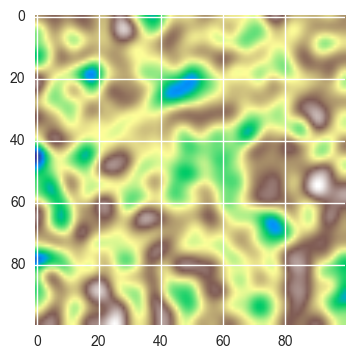

In [90]:
def fake_func(dim=(100,100), low=500, high=600, sigma=3):
    r = uniform(low, high, size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)
plt.imshow(fake_func((100,100)), cmap=plt.get_cmap("terrain"))
plt.show()

surf=fake_func()

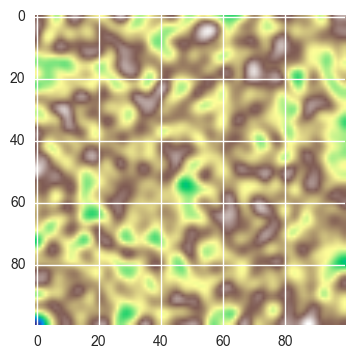

In [91]:
def fake_winddir(dim=(100,100), low=(1), high=(8), sigma=2):
    r = uniform((low), (high), size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)
plt.imshow(fake_wind((100,100)), cmap=plt.get_cmap("terrain"))
plt.show()

winddirection=fake_winddir()

In [92]:
winddirection=surf2.astype(int)   # winddirection can be 1,2,...8
winddirection   
    

array([[4, 4, 4, ..., 4, 3, 3],
       [4, 4, 4, ..., 4, 4, 3],
       [4, 4, 4, ..., 4, 4, 4],
       ..., 
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 3, ..., 4, 3, 3]])

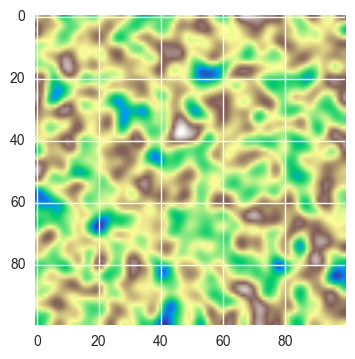

In [93]:
def fake_windspeed(dim=(100,100), low=1, high=200, sigma=2):  # wind speed can be between 1 to 200km/h, if it is too mild (less than 10), it doesnt convey to neighbor pixels. 
    r = uniform((low), (high), size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)
plt.imshow(fake_windspeed((100,100)), cmap=plt.get_cmap("terrain"))
#plt.show()

windsp=fake_windspeed()

In [94]:
class TreeCell(Agent):

    def __init__(self, pos, model):

        Agent.__init__(self, pos, model)
        self.pos = pos
        self.condition = "Fine"
        self.height = surf[pos]
        self.winddirect=winddirection[pos]
        self.windspeed=windsp[pos]

    def step(self):

        if self.condition == "OnFire":
            for neighbor in self.model.grid.neighbor_iter(self.pos):
                if neighbor.condition == "Fine" and neighbor.height>=self.height and neighbor.winddirect==self.winddirect and neighbor.windspeed>10:
                    neighbor.condition = "OnFire"
            self.condition = "BurnedOut"
        
    def get_pos(self):
        return self.pos

In [95]:
class ForestFire(Model):

    def __init__(self, height, width, density):
        self.height = height
        self.width = width
        self.density = density
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        
        
        self.datacollector = DataCollector(
            {"Fine": lambda m: self.count_type(m, "Fine"),
             "OnFire": lambda m: self.count_type(m, "OnFire"),
             "BurnedOut": lambda m: self.count_type(m, "BurnedOut")})

        for (contents,x,y) in self.grid.coord_iter():
            if random.random() < self.density:
                new_tree = TreeCell((x, y), self)
                if x == 0:
                    new_tree.condition = "OnFire"
                self.grid._place_agent((x, y), new_tree)
                self.schedule.add(new_tree)
        self.running = True
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        if self.count_type(self, "OnFire") == 0:
            self.running = False

    @staticmethod
    def count_type(model, tree_condition):
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

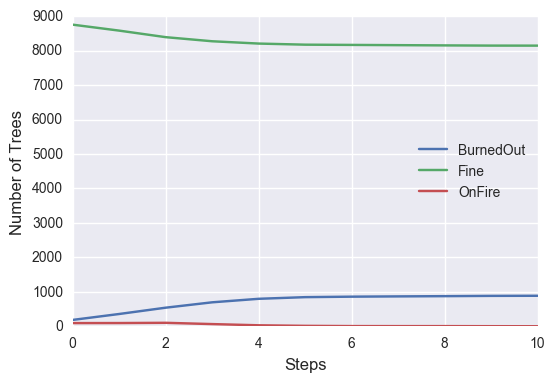

In [96]:
fire=ForestFire(100, 100, 0.9)
fire.run_model()
results = fire.datacollector.get_model_vars_dataframe()
results.plot()
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Number of Trees', fontsize=12)
plt.show()

100%|████████████████████████████████████████| 100/100 [00:24<00:00,  1.70it/s]


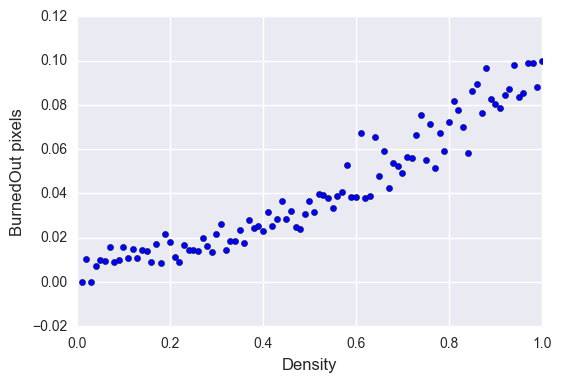

In [85]:
param_set = dict(height=100, width=100,density=np.linspace(0,1,101)[1:]) 
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "BurnedOut") / 
                                         m.schedule.get_agent_count()) }
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)
plt.xlabel('Density', fontsize=12)
plt.ylabel('BurnedOut pixels', fontsize=12)
